# Demo for Connectivity Optimization with Undirected Graph

## 1 Experimental Setup

Predefined graph: 6-nodes, sparse connection with edge weights 0.6

Data generalization according to GRMF: given $\mathbf{y}|\mathbf{x},\mathbf{L}\sim \mathcal{N}(\mathbf{x},\sigma^2\mathbf{I}), \mathbf{x}|\mathbf{L}\sim\mathcal{N}(\mathbf{0},\mathbf{L}^\dagger)$, generate $\mathbf{y}|\mathbf{L}\sim\mathcal{N}(\mathbf{0},\sigma^2\mathbf{I}+\mathbf{L}^\dagger)$

Data number in total: 128

In [1]:

# Graph design
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
from scipy.sparse.csgraph import laplacian
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def draw_graph_from_adj(adj, title=None):
    G = nx.from_numpy_array(adj.numpy())
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    edge_labels = {(u, v): f'{d["weight"]:.1f}' for (u, v, d) in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    if title is not None:
        plt.title(title)
    plt.show()

def generate_graph_from_edges(num_nodes, edges, weights=None):
    if weights is None:
        weights = torch.ones(len(edges))
    adj = torch.zeros((num_nodes, num_nodes))
    adj[edges[:, 0], edges[:, 1]] = weights
    adj = adj + adj.t()  # make it symmetric
    adj.fill_diagonal_(0)  # remove self-loops
    # For visualization only (using scipy sparse)
    draw_graph_from_adj(adj)
    return adj


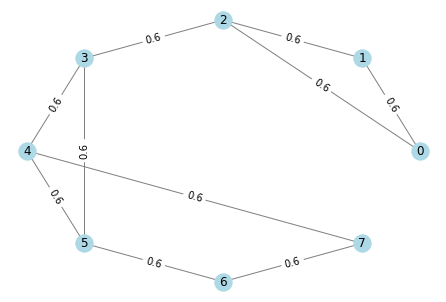

tensor(7.2000)
[[ 1.2       -0.6       -0.6       -0.        -0.        -0.
  -0.        -0.       ]
 [-0.6        1.2       -0.6       -0.        -0.        -0.
  -0.        -0.       ]
 [-0.6       -0.6        1.8000001 -0.6       -0.        -0.
  -0.        -0.       ]
 [-0.        -0.        -0.6        1.8000001 -0.6       -0.6
  -0.        -0.       ]
 [-0.        -0.        -0.        -0.6        1.8000001 -0.6
  -0.        -0.6      ]
 [-0.        -0.        -0.        -0.6       -0.6        1.8000001
  -0.6       -0.       ]
 [-0.        -0.        -0.        -0.        -0.        -0.6
   1.2       -0.6      ]
 [-0.        -0.        -0.        -0.        -0.6       -0.
  -0.6        1.2      ]]


In [2]:
edges = edges = [[0,1],[0,2],[1,2],[2,3],[3,4],[4,5],[3,5],[5,6],[6,7], [4,7]]
edges = torch.tensor(edges)
weights = torch.tensor([0.6]*len(edges))
num_nodes = 8
adj = generate_graph_from_edges(num_nodes, edges, weights)
print(adj.norm()**2)
L = laplacian(adj, normed=False)
print(L)
# generate data


## 2 Graph Learning Module (Simple)

- Define a *learnable* embedding for each node, the embedded signals $\tilde{\mathbf{x}}_i = [x_i;\mathbf{e}_i]$
- Feature extraction: A single linear layer with activation `LeakyReLU(0.2)`: $\mathbf{f}_i = \sigma(\mathbf{H}\tilde{\mathbf{x}}_i+\mathbf{h})$
- Weight calculation: $w_{i,j}=\alpha\exp(-\Vert \mathbf{f}_i - \mathbf{f}_j \Vert_2^2)$
- Laplacian matrix: $\mathbf{L}=\text{diag}(\mathbf{W1})-\mathbf{W}$

Parameters: $\Theta=(\{\mathbf{e}_i\}_{i=1}^{N}, \mathbf{H},\mathbf{h})$

In [3]:
class GraphLearningModule(nn.Module):
    # generate weight matrix from node embeddings
    def __init__(self, num_nodes, emb_dim=6, feature_dim=3, c=8):
        super(GraphLearningModule, self).__init__()
        self.num_nodes = num_nodes
        self.emb_dim = emb_dim
        self.feature_dim = feature_dim

        # embedding vectors
        self.node_embeddings = nn.Parameter(torch.randn(num_nodes, emb_dim))  
        self.fc = nn.Linear(emb_dim, feature_dim)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.c = c

    def forward(self, x, params=None):
        """
        x: (B, N)
        params: dict[str, tensor] (可选，用于 MAML/unrolled optimization)
        """
        if params is None:
            node_embeddings = self.node_embeddings
            fc_weight = self.fc.weight
            fc_bias = self.fc.bias
        else:
            node_embeddings = params["node_embeddings"]
            fc_weight = params["fc.weight"]
            fc_bias = params["fc.bias"]

        B = x.size(0)

        # 1. embed each node
        e = x.unsqueeze(-1) + node_embeddings.unsqueeze(0)  # (B, N, emb_dim)

        # 2. linear + activation
        f = F.linear(e, fc_weight, fc_bias)   # (B, N, feature_dim)
        f = self.leakyrelu(f)

        # 3. pairwise difference
        df = f.unsqueeze(2) - f.unsqueeze(1)  # (B, N, N, feature_dim)

        # 4. adjacency by RBF kernel
        adj = torch.exp(-(df ** 2).sum(-1)).mean(0)  # (N, N)
        adj.fill_diagonal_(0)

        return adj

## 3 GEM Algorithm
### 3.1 Hard E-step: Update $\mathbf{x}$
$$
\min_x \Vert \mathbf{y}-\mathbf{x}\Vert_2^2 + \mu \mathbf{x}^\top\mathbf{Lx}\\
\mathbf{x}^*=(\mathbf{I}+\mu\mathbf{L})^{-1}\mathbf{y}
$$
In practice, solve in CG

Update graph with new $\mathbf{x}$ and project it to the sphere
### 3.2 M-step-1: update graph weights $\Theta$
$$
\min_\Theta \mathbf{x}^\top\mathbf{Lx} \quad \text{s.t. }~ \Vert \mathbf{W}\circ\mathbf{S} \Vert_2^2=c
$$
Projected Gradient Method:
1. Gradient step: $\Theta^{t+1} = \Theta^{t} - \delta^{t}\nabla_\Theta(\mathbf{x}^\top\mathbf{L^tx})$
2. Recompute graph: $\mathbf{W}^{t+1} = \mathbf{W}(\Theta^{t+1})$
3. Project to the sphere: $\alpha \leftarrow \frac{\sqrt{c}}{\Vert \mathbf{W}^{t+1} \Vert_F} \alpha$
### 3.3 M-step-2 update graph connectivity $\mathbf{S}$
$$
\min_{\mathbf{S}\in\{0,1\}^{N\times N}} \mathbf{x}^\top\mathbf{Lx} + \gamma \Vert \mathbf{S}\Vert_{0,\text{off}}
$$
Greedy approach:
1. Sort $Q_{i,j} = \frac{1}{2W_{i,j}}(x_i-x_j)^2+\frac{\gamma}{W_{i,j}^2}$ in ascending order $\iff$ Sort $Q'_{i,j}=W_{i,j}^2 / [\frac{1}{2}W_{i,j}(x_i-x_j)^2 + \gamma]$ in descending order (to avoid division by zeros)
2. Select edges according to ascending $Q$ until reaches $\Vert\mathbf{W}\Vert_F^2=c$.

In [4]:
import math
def Laplacian_from_adj(adj):
    D = torch.diag(adj.sum(1))
    L = D - adj
    return L

def GLR(x, L):
    # x in shape (B, N), L in shape (N, N)
    return torch.trace(x @ L @ x.t()) / x.size(0) # scalar, mean of GLR over batch

class GEM(nn.Module):
    def __init__(self, num_nodes, mu, gamma, step_size, emb_dim=6, feature_dim=3, c=8, scale=True):
        super(GEM, self).__init__()
        self.glm = GraphLearningModule(num_nodes, emb_dim, feature_dim, c)
        # self.S = torch.ones((num_nodes, num_nodes)) - torch.eye(num_nodes)  # all-one matrix with zero diagonal
        self.mu = mu
        self.c = c
        self.step_size = step_size
        self.gamma = gamma
        self.scale = scale
    
    def scale_W(self, adj, S):
        W = adj * S
        scale_factor = 1
        if self.scale:
            scale_factor = math.sqrt(self.c) / W.norm() if W.norm() != 0 else 1
            W = W * scale_factor
        return W, scale_factor

    def E_step(self, y, W):
        # y in (B, N)
        B = y.size(0)
        D = torch.diag(W.sum(1))
        L = D - W
        cov = torch.eye(self.glm.num_nodes) + self.mu * L
        return torch.linalg.solve(cov, y.t()).t()  # return in shape (B, N)
    
    def M_step_1(self, x, L):
        loss = GLR(x, L)
        # backward to gradient descent
        grads = torch.autograd.grad(loss, self.glm.parameters(), create_graph=True)
        new_params = {}
        for (name, param), grad in zip(self.glm.named_parameters(), grads):
            new_params[name] = param - self.step_size * grad
        return new_params
    
    def M_step_2(self, x, W):
        N = self.glm.num_nodes

        # --------- Step 1: compute dis_x_2 efficiently ---------
        x_sq = (x ** 2).mean(0)                     # (N,)
        cross = (x.T @ x) / x.shape[0]              # (N, N)
        dis_x_2 = x_sq[:, None] + x_sq[None, :] - 2 * cross

        # --------- Step 2: take only upper-triangular entries ---------
        idx = torch.triu_indices(N, N, offset=1)
        W_flatten = W[idx[0], idx[1]]
        dis_x_2_flatten = dis_x_2[idx[0], idx[1]]

        # --------- Step 3: compute Q and sort ---------
        Q_flatten = W_flatten**2 / (dis_x_2_flatten * W_flatten / 2 + self.gamma)
        Q_sorted, Q_indices = torch.sort(Q_flatten, descending=True)

        # --------- Step 4: select edges with cumulative sum ---------
        W_sq_sorted = W_flatten[Q_indices] ** 2
        cum_w = torch.cumsum(W_sq_sorted, dim=0)
        last_idx = torch.searchsorted(cum_w, self.c / 2).item()
        print(f'Number of selected edges: {last_idx}')
        # print(f'total energy of selected edges: {cum_w[last_idx-1]:.4f}')

        selected = torch.zeros_like(W_flatten)
        selected[Q_indices[:last_idx]] = 1
        # print('selected edges energy:', (W_flatten * selected).norm()**2)

        # --------- Step 5: build symmetric S ---------
        S = torch.zeros((N, N), device=W.device)
        S[idx[0], idx[1]] = selected
        # print('selected edges energy:', (S * W).norm()**2)
        S = S + S.T
        print('selected edges energy:', (S * W).norm()**2)
        S.fill_diagonal_(0)

        return S
    # needs to be further simplified to be more efficient


    def single_step(self, y, adj, S, params=None):
        # y in (B, N)
        B = y.size(0)
        W0, _ = self.scale_W(adj, S)

        # E-step
        x = self.E_step(y, W0)
        # recompute graph
        adj1 = self.glm(x, params=params) # unregularized adjacency
        W1, _ = self.scale_W(adj1, S)  # element-wise product to enforce sparsity pattern
        L1 = torch.diag(W1.sum(1)) - W1
        print(f'after E-step: delta_W norm {torch.norm(W1 - W0):.4f}, GLR {GLR(x, L1):.4f}, adj norm^2 {adj1.norm()**2:.4f}')

        # M-step-1: minimize GLR
        new_params = self.M_step_1(x, L1) # update parameters in glm
        adj2 = self.glm(x, params=new_params) # unregularized adjacency
        W2, alpha2 = self.scale_W(adj2, S)  # element-wise product to enforce sparsity pattern
        L2 = torch.diag(W2.sum(1)) - W2
        print(f'after M-step-1: delta_W norm {torch.norm(W2 - W1):.4f}, GLR {GLR(x, L2):.4f}, adj norm^2 {adj2.norm()**2:.4f}')

        # M-step-2: optimizing alpha with gradient steps
        S1 = self.M_step_2(x, adj2 * alpha2)
        W3, _ = self.scale_W(adj2, S1)
        L3 = torch.diag(W3.sum(1)) - W3
        print(f'after M-step-2: delta_W norm {torch.norm(W3 - W2):.4f}, GLR {GLR(x, L3):.4f}')
        return x, adj2 * alpha2, S1, params
    
    def forward(self, y, S_init, num_iters=10, adj_init=None, params=None):
        adj = self.glm(y) if adj_init is None else adj_init
        S = S_init
        _, alpha = self.scale_W(adj, S)
        adj = adj * alpha  # scale initial adjacency
        
        for it in range(num_iters):
            print(f'Iteration {it+1}/{num_iters}')
            x, adj, S, params = self.single_step(y, adj, S, params=params)
            W = adj * S
            print('W norm^2 at Iteration', it+1, W.norm()**2)
            draw_graph_from_adj(W.detach().cpu(), title=f'Learned Graph at Iteration {it+1}')
        return x, adj, S

In [5]:
# load data
seed = 0
sigma = 0.5
data = np.load(f'data/graph_data_seed_{seed}_sigma_{sigma}.npz')
y = torch.tensor(data['data'], dtype=torch.float32)  # (n_samples, num_nodes)
num_nodes = y.size(1)


Iteration 1/5
after E-step: delta_W norm 0.2996, GLR 11.3512, adj norm^2 14.5172
after M-step-1: delta_W norm 1.0706, GLR 7.5855, adj norm^2 10.8034
Number of selected edges: 27
selected edges energy: tensor(8.0000, grad_fn=<PowBackward0>)
after M-step-2: delta_W norm 0.0012, GLR 7.0866
W norm^2 at Iteration 1 tensor(8.0000, grad_fn=<PowBackward0>)


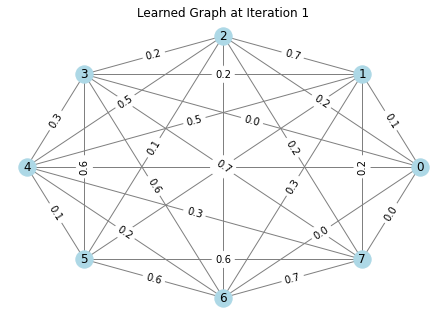

Iteration 2/5
after E-step: delta_W norm 1.0145, GLR 12.8658, adj norm^2 14.0849
after M-step-1: delta_W norm 1.0938, GLR 10.3509, adj norm^2 7.7191
Number of selected edges: 23
selected edges energy: tensor(7.9980, grad_fn=<PowBackward0>)
after M-step-2: delta_W norm 0.0447, GLR 10.4180
W norm^2 at Iteration 2 tensor(7.9980, grad_fn=<PowBackward0>)


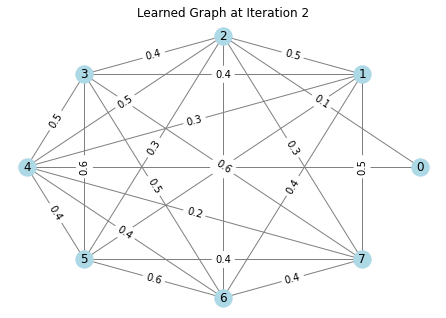

Iteration 3/5
after E-step: delta_W norm 0.9294, GLR 9.7865, adj norm^2 14.2108
after M-step-1: delta_W norm 1.5778, GLR 8.8422, adj norm^2 13.5347
Number of selected edges: 15
selected edges energy: tensor(7.8914, grad_fn=<PowBackward0>)
after M-step-2: delta_W norm 0.3301, GLR 7.9505
W norm^2 at Iteration 3 tensor(7.8914, grad_fn=<PowBackward0>)


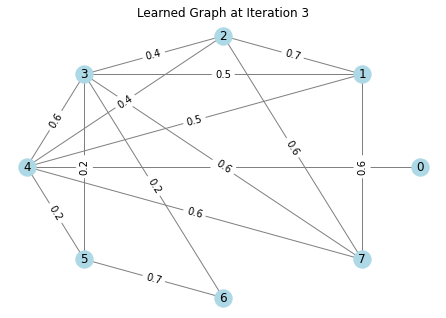

Iteration 4/5
after E-step: delta_W norm 0.9859, GLR 8.4650, adj norm^2 14.0100
after M-step-1: delta_W norm 0.8644, GLR 7.9729, adj norm^2 3.6462
Number of selected edges: 14
selected edges energy: tensor(7.8013, grad_fn=<PowBackward0>)
after M-step-2: delta_W norm 1.5763, GLR 6.8906
W norm^2 at Iteration 4 tensor(7.8013, grad_fn=<PowBackward0>)
Number of selected edges: 14
selected edges energy: tensor(7.8013, grad_fn=<PowBackward0>)
after M-step-2: delta_W norm 1.5763, GLR 6.8906
W norm^2 at Iteration 4 tensor(7.8013, grad_fn=<PowBackward0>)


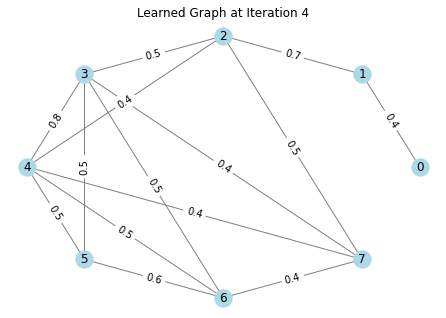

Iteration 5/5
after E-step: delta_W norm 0.8967, GLR 6.4121, adj norm^2 13.0675
after M-step-1: delta_W norm 1.1092, GLR 6.1249, adj norm^2 0.9144
Number of selected edges: 14
selected edges energy: tensor(8.0000, grad_fn=<PowBackward0>)
after M-step-2: delta_W norm 0.0000, GLR 6.1249
W norm^2 at Iteration 5 tensor(8.0000, grad_fn=<PowBackward0>)
after M-step-1: delta_W norm 1.1092, GLR 6.1249, adj norm^2 0.9144
Number of selected edges: 14
selected edges energy: tensor(8.0000, grad_fn=<PowBackward0>)
after M-step-2: delta_W norm 0.0000, GLR 6.1249
W norm^2 at Iteration 5 tensor(8.0000, grad_fn=<PowBackward0>)


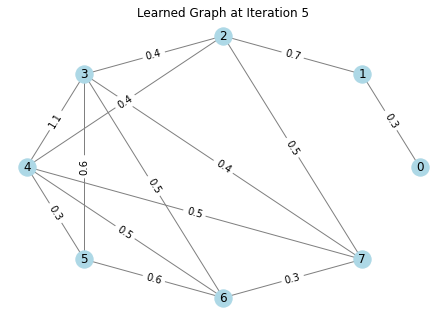

Final learned adjacency matrix:
tensor([[0.0000, 0.3150, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3150, 0.0000, 0.6593, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6593, 0.0000, 0.3716, 0.3501, 0.0000, 0.0000, 0.4571],
        [0.0000, 0.0000, 0.3716, 0.0000, 1.0930, 0.5502, 0.5263, 0.4176],
        [0.0000, 0.0000, 0.3501, 1.0930, 0.0000, 0.3172, 0.4923, 0.4825],
        [0.0000, 0.0000, 0.0000, 0.5502, 0.3172, 0.0000, 0.5915, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5263, 0.4923, 0.5915, 0.0000, 0.3494],
        [0.0000, 0.0000, 0.4571, 0.4176, 0.4825, 0.0000, 0.3494, 0.0000]],
       grad_fn=<MulBackward0>) tensor(8.0000, grad_fn=<PowBackward0>)


In [6]:
torch.manual_seed(42)
gem = GEM(num_nodes, mu=0.25, gamma=0.1, step_size=0.08, c=8, scale=True)
# initialize adjacency and S
# adj_init = torch.ones((num_nodes, num_nodes)) - torch.eye(num_nodes)  # all-one matrix with zero diagonal
S_init = torch.ones((num_nodes, num_nodes)) - torch.eye(num_nodes)  # all-one matrix with zero diagonal
# run GEM
# with torch.no_grad():
    # draw_graph_from_adj(adj_init, title='Initial Graph')
x_final, adj_final, S_final = gem(y, S_init, num_iters=5)
W_final = adj_final * S_final
print("Final learned adjacency matrix:")
print(W_final, W_final.norm()**2)

In [7]:
# class GraphLearningModule(nn.Module):
#     # generate weight matrix from node embeddings
#     def __init__(self, num_nodes, emb_dim=6, feature_dim=3, alpha=1.0, c=8):
#         super(GraphLearningModule, self).__init__()
#         self.num_nodes = num_nodes
#         # embedding vectors
#         self.node_embeddings = nn.Parameter(torch.randn(num_nodes, emb_dim))  # emb_dim-dimensional embeddings
#         self.fc = nn.Linear(emb_dim, feature_dim)
#         self.leakyrelu = nn.LeakyReLU(0.2)
#         # self.alpha = alpha # scaling factor by calculation
#         self.c = c

#     # def scale_alpha(self, adj):
#     #     # scale alpha such that norm(alpha * adj) = c
#     #     current_norm = torch.norm(self.alpha * adj)
#     #     print('current norm', current_norm)
#     #     scaling_factor = self.c / current_norm**2 if current_norm != 0 else 1
#     #     self.alpha *= scaling_factor
#     #     return scaling_factor

#     def forward(self, x):
#         # x: (batch_size, num_nodes)
#         B = x.size(0)
#         # embed each node
#         # Expand node_embeddings to batch dimension and add directly to x
#         e = x.unsqueeze(-1) + self.node_embeddings.unsqueeze(0) # in shape (B, N, emb_dim)
#         f = self.leakyrelu(self.fc(e)) # in shape (B, N, feature_dim)
#         df = f.unsqueeze(2) - f.unsqueeze(1) # in shape (B, N, N, feature_dim)
#         # dis = torch.norm(df, dim=-1)
#         adj = torch.exp(-(df**2).sum(-1)).mean(0) # in shape (N, N)
#         adj.fill_diagonal_(0)
#         # print('adj before scaling', adj, adj.norm()**2, self.alpha)
#         # scaling_factor = self.scale_alpha(adj)
#         # print('scale', scaling_factor)
#         # adj = adj * scaling_factor
#         # print(self.alpha)
#         return adj
    
